In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


2025-06-30 11:48:26.652388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751298506.739647    3789 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751298506.765519    3789 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751298506.982421    3789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751298506.982532    3789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751298506.982536    3789 computation_placer.cc:177] computation placer alr

In [2]:
# ===== Config =====
IMG_SHAPE = (64, 64, 3)
BATCH_SIZE = 32
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE
DATA_DIR = '../data'
MODEL_DIR = os.path.join('../models', 'eye_state_model')
os.makedirs(MODEL_DIR, exist_ok=True)

LABELS = {'awake': 1, 'sleepy': 0}


In [3]:
# ===== Data augmentation =====
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

W0000 00:00:1751298515.313281    3789 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# ===== Dataset helpers =====
def get_image_paths_and_labels(split):
    image_paths, labels = [], []
    for category, label in LABELS.items():
        folder = os.path.join(DATA_DIR, split, category)
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            if os.path.isfile(fpath):
                image_paths.append(fpath)
                labels.append(label)
    return image_paths, labels

def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_with_aug(path, label):
    image, label = preprocess(path, label)
    image = data_augment(image)
    return image, label

def create_dataset(split, augment=False):
    paths, labels = get_image_paths_and_labels(split)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    map_fn = preprocess_with_aug if augment else preprocess
    ds = ds.map(map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

In [5]:
# ===== Load datasets =====
train_ds = create_dataset("train")
val_ds = create_dataset("val")
test_ds = create_dataset("test")

In [7]:

# ===== Sanity check label balance =====
# _, y_train = get_image_paths_and_labels("train")
# _, y_val = get_image_paths_and_labels("val")
# print("Train label counts:", Counter(y_train))
# print("Val label counts:", Counter(y_val))

In [8]:
# ===== Model definition =====
base = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base.trainable = True  # optional: fine-tune later

x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base.input, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


/tmp/ipykernel_3789/227781092.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [9]:
# ===== Callbacks =====
earlystop_cb = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=4,
    restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, 'checkpoint.keras'),
    save_best_only=True
)

# ===== Train =====
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_cb, checkpoint_cb]
)

Epoch 1/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 354s 208ms/step - accuracy: 0.8913 - auc: 0.4473 - loss: 0.2824 - precision: 0.9572 - recall: 0.9158 - val_accuracy: 0.5072 - val_auc: 0.4900 - val_loss: 1.0302 - val_precision: 0.5998 - val_recall: 0.0783
Epoch 2/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 332s 209ms/step - accuracy: 0.7847 - auc: 0.4436 - loss: 0.6774 - precision: 0.9417 - recall: 0.7991 - val_accuracy: 0.5302 - val_auc: 0.4345 - val_loss: 1.1764 - val_precision: 0.7739 - val_recall: 0.1008
Epoch 3/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 330s 207ms/step - accuracy: 0.8187 - auc: 0.4591 - loss: 0.5542 - precision: 0.9511 - recall: 0.8324 - val_accuracy: 0.6222 - val_auc: 0.5977 - val_loss: 0.9586 - val_precision: 0.9470 - val_recall: 0.2683
Epoch 4/20
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 324s 204ms/step - accuracy: 0.8506 - auc: 0.4772 - loss: 0.4462 - precision: 0.9633 - recall: 0.8593 - val_accuracy: 0.7310 - val_auc: 0.7355 - val_loss: 0.7023 - val_precision: 0.9820 - val_recall: 0.4771
Epoch 5/

In [10]:
# ===== Save full model in SavedModel format =====
model.save("../models/eye_state_model.keras")
model.export(MODEL_DIR)
print(f"✅ Model saved to {MODEL_DIR}/")

INFO:tensorflow:Assets written to: ../models/eye_state_model/assets


INFO:tensorflow:Assets written to: ../models/eye_state_model/assets


Saved artifact at '../models/eye_state_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140181479949328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479950096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479950672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479949904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479951248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479950480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479951824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479952784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479952400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140181479950864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401814

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━

2025-06-30 13:39:21.328096: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


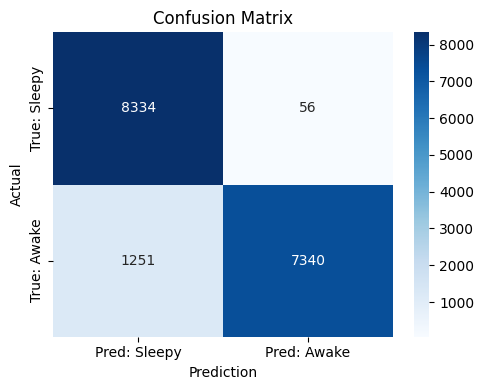

In [11]:
# ===== Evaluate on test_ds =====
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Sleepy (0)", "Awake (1)"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Sleepy", "Pred: Awake"],
            yticklabels=["True: Sleepy", "True: Awake"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()